## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#Read the ab_data.csv file in DataFrame called df.
df = pd.read_csv('ab_data.csv',delimiter=',')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# shape and data types of the data
print(df.shape)
print(df.dtypes)

(294478, 5)
user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object


c. The number of unique users in the dataset.

In [4]:
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [5]:
#proportion of users converted by taking mean since values are 1 and 0
print("Converted users proportion is {}%".format((df['converted'].mean())*100))

Converted users proportion is 11.96591935560551%


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df['user_id'].count() - df.query('landing_page == "new_page" and group == "treatment" or group == "control" and landing_page == "old_page"')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df_1 = df[(df.group == 'treatment') & (df.landing_page == 'new_page')] 
df_2 = df[(df.group == 'control') & (df.landing_page == 'old_page')] 
frames = [df_1, df_2]
df2 = pd.concat(frames)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
# show rows duplicated in user_id
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Drop one of the rows that belongs to the repeated user_id

df2 = df2.drop_duplicates(subset='user_id');

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group =="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group =="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"')['landing_page'].count() / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Looking at the question results I can explain if I think there is sufficient evidence to say that the new treatment page leads to more conversions.**

Given that an individual was in the treatment group, the probability they converted is 0.118807
Given that an individual was in the control group, the probability they converted is 0.120386
Given the nearly identical performance of both pages, we cannot confirm with certainty that one page leads to more conversions.
However, further analysis is possible to investigate if other effects were influencing this result

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null Hypotheses : if p-value is less than 5%, the old page has a higher chance of converting users.**
**Alternative Hypotheses: if p-value is equal to or greater than 5%, then the new page has a higher chance of converting users.**

Null hypotheses: $p_{old}$ - $p_{new}$ <= 0

Alternative hypotheses: $p_{old}$ - $p_{new}$ > 0



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
#calculate number of queries when landing_page is equal to new_page
n_new = df2.query('landing_page== "new_page" and group=="treatment"').shape[0]
print('The number of individuals in the treatment group n_𝑛𝑒𝑤 : {}'.format(n_new))

The number of individuals in the treatment group n_𝑛𝑒𝑤 : 145310


d. What is $n_{old}$?

In [21]:
#calculate number of queries when landing_page is equal to old_page
n_old = df2.query('landing_page== "old_page" and group=="control"').shape[0]
print('The number of individuals in the control group n_𝑜𝑙𝑑 : {}'.format(n_old))

The number of individuals in the control group n_𝑜𝑙𝑑 : 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# to simulate n_new transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# to simulate n_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])
old_page_converted

array([1, 0, 1, ..., 0, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# differences between p_new and p_old
diff= new_page_converted.mean() - old_page_converted.mean()
diff

-0.001264320283805076

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])
    old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [26]:
# putting simulated data in numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

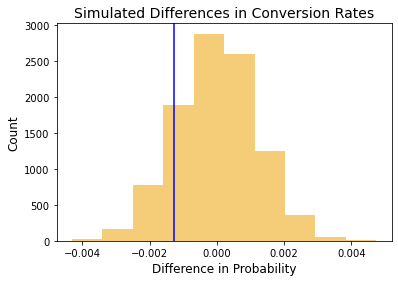

In [27]:
p_diffs=np.array(p_diffs)

plt.hist(p_diffs,color='#f5cd79')
plt.title("Simulated Differences in Conversion Rates", fontsize=14)
plt.xlabel("Difference in Probability", fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(diff, color='blue');


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Calculate the actucl difference observed in ab_data

page_old_mean = df.query('group =="control"').converted.mean()
page_new_mean = df.query('group =="treatment"').converted.mean()
page_diff = page_new_mean - page_old_mean


# Calculate the propotion of the p_diffs are greater than the actual difference observed in ab_data.csv
(p_diffs > page_diff).mean()

0.8871

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Q. What you just computed in part j?**

**This part computes the proportion of the p_diffs values that are greater than the actual difference observed in the data frame**

**Q. What is this value called in scientific studies?**

**This value called p-value**

**Q. What does this value mean in terms of whether or not there is a difference between the new and old pages?**

**When the p-value is equal to 0.8871 that means we accept the null hypothesis. The null hypothesis said there are no changes in page converted performance between the old and new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2.query('landing_page== "old_page"').shape[0]
n_new = df2.query('landing_page== "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

print('z_score : {}'.format(z_score))
print('p_value : {}'.format(p_value))

z_score : -1.3109241984234394
p_value : 0.9050583127590245


In [31]:
from scipy.stats import norm
print('significant z-score is : {}'.format(norm.cdf(z_score)))
# critical value at 95% confidence is
print('What critical value at 95% confidence is : {}'.format(norm.ppf(1-(0.05/2))))

significant z-score is : 0.09494168724097551
What critical value at 95% confidence is : 1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score of -1.3109241984234394 does not exceed the critical value of 1.959963984540054, we fail to reject the null hypothesis that old page users has a better or equal converted rate than old page users. Therefore, the converted rate for new page and old page have no difference. The p_value does not match as parts j and k ,however, this conclusion is the same.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**we are trying to classify weather a conversion happens or not.Therefore this is a case for logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
import statsmodels.api as sm
model_page=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model_page.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
# to print out the summary
print (results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        13:55:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**In Part II we assume the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, compared to question c-e, they have different explanatory variables or factors for the result. The p-value associated with ab_page is 0.190. The null hypothesis in the c-e part is that there is no difference between the treatment and control group. An alternative hypothesis is that there is a difference between the treatment and control groups.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Another factor Another factor can be the time. We can check if the converted rate depends on a certain time of the day or a certain day when users browse the website. The disadvantage of adding additional terms into the regression model is that it will make interpretation to the model more complex and indeed if we add new terms which increase the number of dependable variables with the existing explanatory term, we need to add a higher-order term to help predict the result better. And this is similar to adding to the country-based factor.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
# Read and store the countries dataset
countries_df = pd.read_csv('countries.csv')

#Join the working dataset with country dataset
df3 = df2.merge(countries_df, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [36]:
# get the names of countries
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
#get dummy variables with 'CA' as the baseline
df3[['CA','US', 'UK']] = pd.get_dummies(df3['country'])[['CA','US', "UK"]]
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US,UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [38]:
#Create intercept variable
df3['intercept'] = 1

#Create Logit regression model for conveted and country, and us CA as baseline
Model_loc = sm.Logit(df3['converted'], df3[['intercept','UK','US']])
result2 = Model_loc .fit()
print (result2.summary())

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Jan 2021   Pseudo R-squ.:               1.521e-05
Time:                        13:55:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.

In [39]:
np.exp(result2.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

In [40]:
1/_

intercept    7.671651
UK           0.950546
US           0.960018
dtype: float64


* If an individual has located in the UK the page, they are 0.95 times more likely to be converted than if has located in the CA, holding all other variables constant.
* If an individual has located in the US the page, they are 0.96 times more likely to be converted than if has located in the CA, holding all other variables constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US,UK
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [42]:
#Create a new intereacton variable between new page and country US and UK
df3['UK_new_page'] = df3['ab_page']* df3['UK']
df3['US_new_page'] = df3['ab_page']* df3['US']

In [43]:
#Create logistic regression for the intereaction variable between new page and country using dummy variable
logit2 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK_new_page','US_new_page','UK','US']])

In [44]:
result3 = logit2.fit()
print(result3.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 01 Jan 2021   Pseudo R-squ.:               3.482e-05
Time:                        13:55:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page        -0.0674    

In [45]:
np.exp(result3.params)

intercept      0.134794
ab_page        0.934776
UK_new_page    1.081428
US_new_page    1.048001
UK             1.011854
US             1.017682
dtype: float64

In [46]:
1/_

intercept      7.418713
ab_page        1.069775
UK_new_page    0.924703
US_new_page    0.954198
UK             0.988285
US             0.982625
dtype: float64

From the above Logit Regression Results, we can see the coefficient of interaction variable "UK_new_page" and "US_new_page" are different from the coefficient of the new_page itself. Also, only the intercept's p-value is less than 0.05, which is statistically significant enough for the converted rate. Other variables in the summary are not statistically significant. Therefore, the country factor is not significant on the converted rate considering the type of the page either is old or new.

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1

### Resources:

>Udacity Nanodegree Course

>http://knowledgetack.com/python/statsmodels/proportions_ztest/

>https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html

>https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

>https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
